In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg
import time

import sys
sys.path.insert(0, '..')
import specsens as ss

---- Simulation parameter ----
Generations:    300
Iterations:     300
Total Iters:    90000
Signal power:   0.00 dB
Noise power:    13.00 dB
SNR:            -13.00 dB
Signal length:  0.001024 sec
Signal samples: 1024
---- Simulation stats theory ----
Prob false alarm 0.1000
Prob detection   0.6145
Threshold        21253.8895
---- Running simulation ----
   infs left at  0.00%
 50.38s left at  0.33%
 52.60s left at  0.67%
 53.93s left at  1.00%
 49.22s left at  1.33%
 49.23s left at  1.67%
 47.83s left at  2.00%
 48.54s left at  2.33%
 48.41s left at  2.67%
 48.75s left at  3.00%
 47.28s left at  3.33%
 47.53s left at  3.67%
 46.74s left at  4.00%
 46.90s left at  4.33%
 46.26s left at  4.67%
 47.92s left at  5.00%
 45.83s left at  5.33%
 47.67s left at  5.67%
 47.03s left at  6.00%
 46.95s left at  6.33%
 46.54s left at  6.67%
 46.76s left at  7.00%
 45.46s left at  7.33%
 46.21s left at  7.67%
 45.51s left at  8.00%
 47.46s left at  8.33%
 45.86s left at  8.67%
 54.93s left at  9.00%

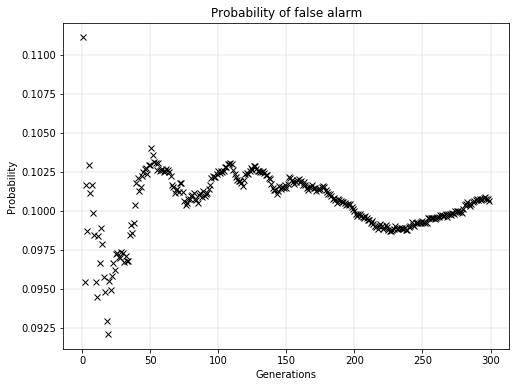

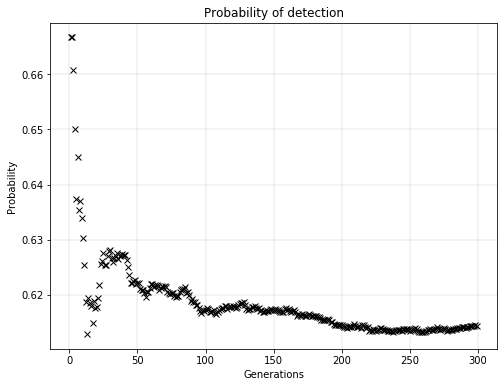

In [8]:
class MonteCarloSim():
    def __init__(self, gens, itrs, f_sample=1e6):
        self.gens = gens  # Number of generations
        self.itrs = itrs  # Number of iterations per generation
        self.f_sample = f_sample  # Sample frequency
        self.reset()

    def reset(self):
        self.pfas = list()  # Probability of false alarm list
        self.pds = list()  # Probability of detection list
        self.time = None

    def run(self,
            signal_strength=0.,
            noise_strength=0.,
            length_sec=None,
            num_samples=None,
            theo_pfa=0.1,
            threshold=None,
            noise_un=0.):

        # Reset simulation state
        self.reset()

        # Check and calculate length, in seconds and number of samples
        if num_samples is not None:
            assert num_samples > 0., 'num_samples must be greater than 0'
            length_sec = num_samples / self.f_sample
        elif length_sec is not None:
            assert length_sec > 0., 'length_sec must be greater than 0'
            length_sec = length_sec
            num_samples = int(self.f_sample * length_sec)
        else:
            assert False, 'either num_samples or length_sec needed'

        # Calculate threshold
        if threshold is None:
            threshold = ss.chi2_stats.get_thr(noise_power=noise_strength,
                                              pfa=theo_pfa,
                                              n=num_samples,
                                              dB=True)

        print('---- Simulation parameter ----')
        print('Generations:    %d' % (self.gens))
        print('Iterations:     %d' % (self.itrs))
        print('Total Iters:    %d' % (self.gens*self.itrs))
        print('Signal power:   %.2f dB' % (signal_strength))
        print('Noise power:    %.2f dB' % (noise_strength))
        print('SNR:            %.2f dB' % (signal_strength - noise_strength))
        print('Signal length:  %.6f sec' % (length_sec))
        print('Signal samples: %d' % (num_samples))

        theo_pd = ss.chi2_stats.get_pd(noise_strength,
                                       signal_strength,
                                       threshold,
                                       num_samples,
                                       dB=True)
        print('---- Simulation stats theory ----')
        print('Prob false alarm %.4f' % (theo_pfa))
        print('Prob detection   %.4f' % (theo_pd))
        print('Threshold        %.4f' % (threshold))
        
        print('---- Running simulation ----')
        # Outer generations loop
        for i in range(self.gens):

            # Create new signal objects for every generation loop
            wm = ss.WirelessMicrophone(f_sample=self.f_sample,
                                       t_sec=length_sec)
            wgn = ss.WhiteGaussianNoise(f_sample=self.f_sample,
                                        t_sec=length_sec)

            # Reset generation stats
            correct_hit = 0
            false_hit = 0
            correct_miss = 0
            false_miss = 0
            times_signal_present = 0

            for j in range(self.itrs):

                # Generate signal, center frequency does not matter with single band ED
                sig = wm.get_soft(f_center=1e5, power=signal_strength, dB=True)

                # Generate noise
                noise = wgn.get_signal(power=noise_strength +
                                       np.random.uniform(-noise_un, noise_un),
                                       dB=True)

                # Randomly decide whether signal should be present
                sig_present = bool(np.random.randint(2))
                if sig_present:
                    both = sig + noise
                    times_signal_present += 1
                else:
                    both = noise

                # Classic (single band) energy detector
                eng = ss.EnergyDetector.get(both)

                # Threshold
                sig_detected = eng > threshold

                # Log signal and detection outcome
                if sig_present and sig_detected:
                    correct_hit += 1
                elif sig_present and not sig_detected:
                    false_miss += 1
                elif not sig_present and sig_detected:
                    false_hit += 1
                else:
                    correct_miss += 1

            # Compute stats and store in list
            pfa_tmp = false_hit / (self.itrs - times_signal_present)
            pd_tmp = correct_hit / times_signal_present
            self.pfas.append(pfa_tmp)
            self.pds.append(pd_tmp)

            # Print simulation progress
            rem, percent = self.runtime_stats(self.gens, i)
            print('%6.2fs left at %5.2f%%' % (rem, percent))

        # Compute stats from lists
        pfa = np.sum(self.pfas) / self.gens
        pd = np.sum(self.pds) / self.gens
        
        print('---- Simulation stats ----')
        print('Prob false alarm theory %.4f' % (theo_pfa))
        print('Prob false alarm sim    %.4f' % (pfa))
        print('Prob detection theory   %.4f' % (theo_pd))
        print('Prob detection sim      %.4f' % (pd))
        
        return pfa, pd

    def runtime_stats(self, total_itr, current_itr):
        if self.time is None:  # First iteration cant predict time
            self.time = time.time()
            return float('inf'), 0.0
        delta_time = time.time() - self.time
        self.time = time.time()
        remaining_itr = total_itr - current_itr
        remaining_time = delta_time * remaining_itr
        percent_done = current_itr / total_itr * 100.0
        return remaining_time, percent_done

    def print_convergence(self):
        plt.figure(figsize=(8, 6))
        plt.title('Probability of false alarm')
        plt.grid(linewidth=0.3)
        for i in range(1, self.gens):
            inter = np.sum(self.pfas[0:i]) / i
            plt.plot(i, inter, 'kx')
        plt.xlabel('Generations')
        plt.ylabel('Probability')
        plt.show()
        plt.figure(figsize=(8, 6))
        plt.title('Probability of detection')
        plt.grid(linewidth=0.3)
        for i in range(1, self.gens):
            inter = np.sum(self.pds[0:i]) / i
            plt.plot(i, inter, 'kx')
        plt.xlabel('Generations')
        plt.ylabel('Probability')
        plt.show()

signal_strength = 0.0  # in dB
noise_strength = 13.0  # in dB
theo_pfa = 0.1  # in percent(0.5 = 50%)
length = 0.001024  # in seconds
sample_freq = 1e6  # sample frequency in Hz

sim = MonteCarloSim(gens=300, itrs=300, f_sample=sample_freq)
pfa, pd = sim.run(signal_strength=signal_strength,
                  noise_strength=noise_strength,
                  length_sec=length,
                  theo_pfa=theo_pfa,
                  noise_un=0.)

sim.print_convergence()